In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 

# Custom functions
from utils import *

# Set style
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 20, 'figure.figsize': (16,9)})

# Define constants

In [2]:
# Get base directory which is two levels up
BASE_DIR = os.path.dirname(os.path.dirname(os.getcwd())) 
print(BASE_DIR)

/net/litho/atmosdyn2/chmony/develop/FoehnDevelopment


# Read North Foehn datasets and stack

In [3]:
location = "LUG" # "PIO" or "LUG"

In [4]:
# Read first timeperiod (1983-2016) and preprocess
df_1983_2016 = pd.read_csv(os.path.join(BASE_DIR, f"data/FoehnData/{location}_1983_2016.txt"), delimiter=",", header=0)
df_1983_2016["Date"] = pd.to_datetime(df_1983_2016["Date"], format='%Y%m%d%H%M')
df_1983_2016.rename(columns= {"Date": "date", "Foehn Index": "Foehn"}, inplace=True)

In [5]:
# Read second timeperiod (2017-2019) and preprocess
df_2017_2019 = pd.read_csv(os.path.join(BASE_DIR, f"data/FoehnData/{location}_2017_2019.txt"), delimiter=";", skiprows=2, header=0)
df_2017_2019["time"] = pd.to_datetime(df_2017_2019["time"], format='%Y%m%d%H%M')
df_2017_2019.rename(columns= {"time": "date", "wcc006s0": "Foehn"}, inplace=True)
df_2017_2019 = df_2017_2019[["date", "Foehn"]]

In [6]:
# Stack dataframes
df_1983_2019 = pd.concat([df_1983_2016, df_2017_2019], axis=0, ignore_index=True)

In [7]:
# Ensure continuous and consistent values in the "date" column
df_timeframe = pd.Series(pd.date_range(start = "1983-01-01 00:00:00", end="2019-12-31 23:50:00", freq="10min"), name="date")
df_1983_2019 = pd.merge(df_timeframe, df_1983_2019, on="date", how="left", validate="one_to_one")

# Preprocess data

In [8]:
# Remove "-" from Foehn column and transform type to float
df_1983_2019["Foehn"] = df_1983_2019["Foehn"].mask(df_1983_2019["Foehn"] =="-", np.NaN)
df_1983_2019["Foehn"] = df_1983_2019["Foehn"].astype(float)

# Set all Foehn values (Foehn==2) to 1 (i.e. treat mixed-foehn as normal foehn)
df_1983_2019["Foehn"] = df_1983_2019["Foehn"].mask(df_1983_2019["Foehn"] == 2.0, 1.0)

In [9]:
df_foehn = generate_aggregated_timeseries(df_1983_2019).reset_index(drop=True)

0.0    50481
1.0     3533
Name: Foehn, dtype: int64


,date,Foehn
0,1983-01-01 00:00:00,0.0
36,1983-01-01 06:00:00,0.0
72,1983-01-01 12:00:00,0.0
108,1983-01-01 18:00:00,0.0
144,1983-01-02 00:00:00,0.0
...,...,...
1945836,2019-12-30 18:00:00,0.0
1945872,2019-12-31 00:00:00,0.0
1945908,2019-12-31 06:00:00,0.0
1945944,2019-12-31 12:00:00,0.0


# Investigate data

In [ ]:
calculate_foehn_length(df_1983_2019.reset_index(drop=True))

Saved figure at: /net/litho/atmosdyn2/chmony/develop/FoehnDevelopment/figures/foehn_climatology_LUG.pdf


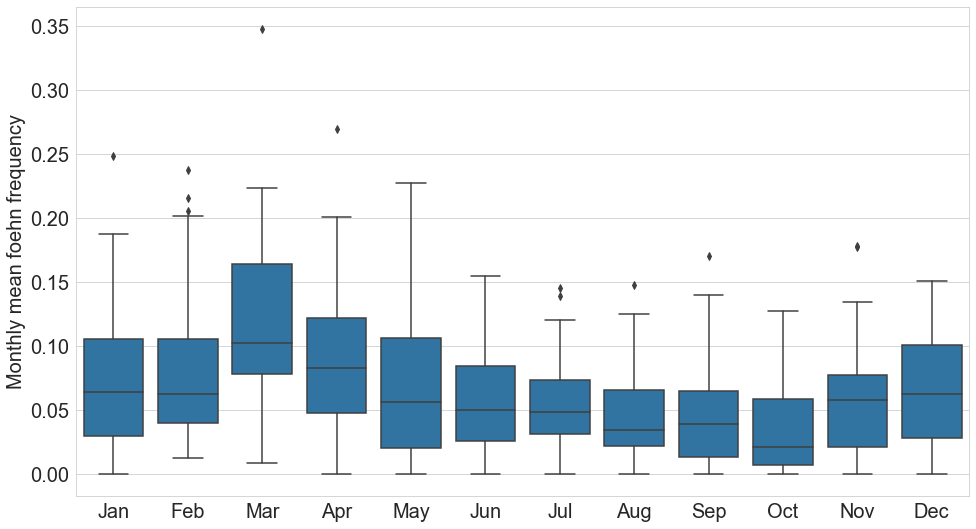

In [11]:
plot_monthly_foehn_distribution(df_1983_2019, location=location)

# Write output

In [12]:
df_foehn.to_csv(os.path.join(BASE_DIR, f"data/FoehnData/{location}_foehn.csv"), index=False)

# Make combined dataframe of ERAI and foehn data

In [17]:
df_ERA = pd.read_csv(os.path.join(BASE_DIR, "data/MeteorologicalData/ERAI_data.csv.gz"), parse_dates=["date"])
df_foehn = df_foehn.dropna()  # Drop missing values
df_ERA_merged = pd.merge(df_foehn, df_ERA, on="date", how="inner")  # Merge where both dataframes have non-missing values
df_ERA_merged.to_csv(os.path.join(BASE_DIR, f"data/FoehnAndMeteorologicalData/ERAI_and_{location}_data.csv.gz"), index=False)